In [1]:
from aiida import load_profile
import typing as t
import json

load_profile("2023-08-07")

from aiida import orm
from aiida_sssp_workflow.calculations.calculate_metric import rel_errors_vec_length

In [2]:
def get_conv_data(i_para, r_para) -> t.Tuple[float, float, float]:
    """Return AE_delta (per atom), AE_nu, REL_nu (the nu compare to the reference not to AE)"""
    AE_delta = i_para['delta/natoms']
    AE_nu = i_para['rel_errors_vec_length']
    
    REFE_delta = r_para['delta/natoms']
    REFE_nu = r_para['rel_errors_vec_length']
    
    AE_delta_abs_diff = abs(AE_delta - REFE_delta)
    AE_nu_abs_diff = abs(AE_nu - REFE_nu)
    
    ref_V0, ref_B0, ref_B1 = r_para['birch_murnaghan_results']
    V0, B0, B1 = i_para['birch_murnaghan_results']

    RELA_nu = rel_errors_vec_length(ref_V0, ref_B0, ref_B1, V0, B0, B1)

    return AE_delta_abs_diff, AE_nu_abs_diff, RELA_nu

In [3]:
def extract_data(node):
    max_cutoff = 0.0
    for wf in node.called:
        if wf.process_label == 'ConvergenceDeltaWorkChain':
            lst = []
            for wf2 in wf.called:

                if wf2.process_label == 'helper_delta_difference':
                    lst.append(wf2)
                if wf2.process_label == 'convergence_analysis':
                    break

        elif wf.process_label.startswith('Convergence'):
            try:
                cutoff = wf.outputs.output_parameters.get_dict()['wavefunction_cutoff']
                if cutoff > max_cutoff:
                    max_cutoff = cutoff
            except Exception as e:
                print(e)
        
        else:
            # parse_pseudo_info or _CachingConvergenceWorkChain
            continue
        
    scan_list = [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100, 120, 150, 200]
    data = {}
    for i, wf in enumerate(lst):
        cutoff = scan_list[i]

        i_para = wf.inputs.input_parameters.get_dict()
        r_para = wf.inputs.ref_parameters.get_dict()
    
        AE_delta_abs_diff, AE_nu_abs_diff, RELA_nu = get_conv_data(i_para, r_para)
        data[cutoff] = {
            "AE_delta": AE_delta_abs_diff,
            "AE_nu_diff": AE_nu_abs_diff,
            "RELA_nu": RELA_nu,
        }
        
    # return two values, the first in the AE_nu_diff (originally used), the second is the REL_nu (we want to use now, which does not depend on the AE info)
    if max_cutoff >= 200:
        return 0, 0

    else:
        ret_AE_nu_diff = data[max_cutoff]['AE_nu_diff']
        ret_RELA_nu = data[max_cutoff]['RELA_nu']

        return ret_AE_nu_diff, ret_RELA_nu
    

In [18]:
def extract_new_data(node):
    for wf in node.called:
        if wf.process_label == 'ConvergenceDeltaWorkChain':
            lst = []
            for wf2 in wf.called:

                if wf2.process_label == 'helper_delta_difference':
                    lst.append(wf2)
                if wf2.process_label == 'convergence_analysis':
                    break
        
        else:
            # parse_pseudo_info or _CachingConvergenceWorkChain
            continue
        
    scan_list = [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100, 120, 150, 200]
    data = {}
    if len(lst) != len(scan_list):
        return None
    for i, wf in enumerate(lst):
        cutoff = scan_list[i]

        i_para = wf.inputs.input_parameters.get_dict()
        r_para = wf.inputs.ref_parameters.get_dict()
    
        AE_delta_abs_diff, AE_nu_abs_diff, RELA_nu = get_conv_data(i_para, r_para)
        data[cutoff] = {
            "AE_delta": AE_delta_abs_diff,
            "AE_nu_diff": AE_nu_abs_diff,
            "RELA_nu": RELA_nu,
        }

    # Get the converge value of AE_nu_diff < 0.01
    max_cutoff = 200
    for cutoff in reversed(scan_list):
        try: 
            ae_diff = data[cutoff]['AE_nu_diff']
        except:
            continue
        
        if ae_diff > 0.01:
            break

        max_cutoff = cutoff
        
    # return two values, the first in the AE_nu_diff (originally used), the second is the REL_nu (we want to use now, which does not depend on the AE info)
    if max_cutoff >= 200:
        return 0, 0

    else:
        try:
            ret_AE_nu_diff = data[max_cutoff]['AE_nu_diff']
            ret_RELA_nu = data[max_cutoff]['RELA_nu']

            #if ret_AE_nu_diff < 0.002:
            #    print(data)

            if ret_RELA_nu - ret_AE_nu_diff < 0.002:
                print(f"A-type: {node.pk}: cutoff = {max_cutoff}, {data[max_cutoff]}")

            if ret_RELA_nu - ret_AE_nu_diff > 0.01:
                print(f"B-type: {node.pk}: cutoff = {max_cutoff}, {data[max_cutoff]}")

            return ret_AE_nu_diff, ret_RELA_nu
        except:
            return None

In [20]:
gs = [
    'lib-NC-SG15/convergence/precision',
    'lib-NC-PSL-1.0.0/convergence/precision',
    'lib-PAW-PSL-1.0.0-high/convergence/precision',
    'lib-PAW-PSL-1.0.0-low/convergence/precision',
    'lib-NC-DOJOv0.5-standard/convergence/precision',
    'lib-US-PSL-0.x/convergence/precision',
]

a_list = []
b_list = []

g1 = orm.Group.collection.get(label='lib-NC-SG15/convergence/precision')
gs_nodes = []
for g in gs:
    gs_nodes.extend(orm.Group.collection.get(label=g).nodes)
    
AE_nu_diff_lst = []
RELA_nu_lst = []
for node in gs_nodes:
    #AE_nu_diff, RELA_nu = extract_data(node)
    ret = extract_new_data(node)
    if ret is None:
        continue

    AE_nu_diff, RELA_nu = ret

    if RELA_nu - AE_nu_diff < 0.002:
        print(f"A-type: {node.pk}")
        a_list.append(node.pk)

    if RELA_nu - AE_nu_diff > 0.01:
        print(f"B-type: {node.pk}")
        b_list.append(node.pk)

    AE_nu_diff_lst.append(AE_nu_diff)
    RELA_nu_lst.append(RELA_nu)

print("A-type:", a_list)
print("B-type:", b_list)

A-type: 2274262: cutoff = 90, {'AE_delta': 0.0005820313729680004, 'AE_nu_diff': 0.000731361713846003, 'RELA_nu': 0.0027193290809509637}
A-type: 2274262
A-type: 2274364: cutoff = 55, {'AE_delta': 0.009997606589579988, 'AE_nu_diff': 0.007017852495129984, 'RELA_nu': 0.007028974547606034}
A-type: 2274364
A-type: 2274432: cutoff = 75, {'AE_delta': 0.045262207080700056, 'AE_nu_diff': 0.008233762439850023, 'RELA_nu': 0.008466707995930918}
A-type: 2274432
A-type: 2274466: cutoff = 90, {'AE_delta': 0.003118220996599863, 'AE_nu_diff': 0.0009908050134200264, 'RELA_nu': 0.0010324810938080577}
A-type: 2274466
A-type: 2274569: cutoff = 120, {'AE_delta': 1.904093709599597e-05, 'AE_nu_diff': 0.0002405935700999784, 'RELA_nu': 0.0007132138552900025}
A-type: 2274569
A-type: 2274603: cutoff = 80, {'AE_delta': 0.002251317643654001, 'AE_nu_diff': 0.006754691130929996, 'RELA_nu': 0.008627734515639236}
A-type: 2274603
A-type: 2274637: cutoff = 90, {'AE_delta': 0.00493605699708001, 'AE_nu_diff': 0.004927094005

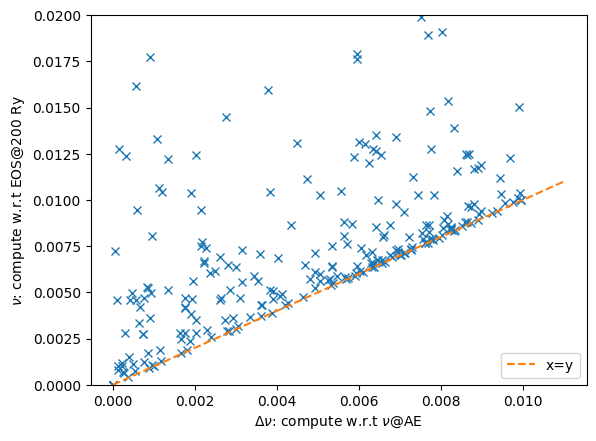

In [6]:
import matplotlib.pyplot as plt

plt.plot(AE_nu_diff_lst, RELA_nu_lst, 'x')
plt.ylim(0, 0.02)
plt.ylabel(r'$\nu$: compute w.r.t EOS@200 Ry')
plt.xlabel(r'$\Delta\nu$: compute w.r.t $\nu$@AE')
plt.plot([0, 0.011], [0, 0.011], '--', label='x=y')
plt.legend()

In [7]:
AE_nu_diff_lst

[0.000731361713846003,
 0.0013440030933450087,
 0.007017852495129984,
 0.009894460494060064,
 0.008233762439850023,
 0.0009908050134200264,
 0.0002405935700999784,
 0.006754691130929996,
 0.004927094005940991,
 0.0037903035862500017,
 0.006376060346339973,
 0.005624424209809964,
 0.007272845463999977,
 0.00467441172067995,
 0.002508793014220023,
 0.006948115487839995,
 0.007635569864600011,
 0.0001305850582600243,
 0.007699811368699905,
 0.008607767103600006,
 0.005957958975859989,
 0.007128490348509986,
 0.007106768308929978,
 0.008242328803714997,
 0.00025936253936997833,
 0.0019380296144499987,
 0.004013331693139999,
 0.003094721498960007,
 0.006566278696749972,
 0.00794523289905999,
 0.008624807770610005,
 0.008029551020559994,
 0.0016656306635899343,
 0.0008295240769099488,
 0.0011698992245790102,
 0.009607156822389995,
 0.000731361713846003,
 0.0013390321524500148,
 0.0028087507648,
 0.006907994282350005,
 0.009925616066043003,
 0.00768882952139005,
 0.006179633965559983,
 0.0020